In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, precision_recall_curve, average_precision_score
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Source and destination paths
source_path = '/content/drive/MyDrive/Research_Vaish/DATASET RAF-DB'
destination_path = '/content/dataset'

In [ ]:
# Remove existing destination directory
if os.path.exists(destination_path):
    shutil.rmtree(destination_path)

In [ ]:
# Create directory and copy dataset
os.makedirs(destination_path, exist_ok=True)
shutil.copytree(source_path, destination_path, dirs_exist_ok=True)

data_dir = destination_path

In [ ]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
# Load dataset
batch_size = 32
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'test'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load ResNet50
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(train_dataset.classes))
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 172MB/s]


In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()
initial_lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

# Trackers
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torchvision import models
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from google.colab import drive

# ==== Mount Google Drive ====
drive.mount('/content/drive')

# ==== Define Save Path ====
save_path = "/content/drive/MyDrive/Research_Vaishnavi/best"
os.makedirs(save_path, exist_ok=True)
save_file = os.path.join(save_path, "best_model_cbam_L1.pth")

# ==== CBAM Definition (Only for Last Layer) ====
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=8):
        super(ChannelAttention, self).__init__()
        self.shared_MLP = nn.Sequential(
            nn.Linear(in_planes, in_planes // ratio),
            nn.ReLU(),
            nn.Linear(in_planes // ratio, in_planes)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=(2, 3), keepdim=False)
        max_out, _ = torch.max(x, dim=2, keepdim=False) # Fix: Apply max sequentially
        max_out, _ = torch.max(max_out, dim=2, keepdim=False) # Fix: Apply max sequentially
        avg_out = self.shared_MLP(avg_out)
        max_out = self.shared_MLP(max_out)
        out = avg_out + max_out
        return self.sigmoid(out).unsqueeze(2).unsqueeze(3)

class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        x_out = self.conv(x_cat)
        return self.sigmoid(x_out)

class CBAM_LastLayer(nn.Module):
    def __init__(self, in_channels):
        super(CBAM_LastLayer, self).__init__()
        self.ca = ChannelAttention(in_channels)
        self.sa = SpatialAttention()

    def forward(self, x):
        x = x * self.ca(x)
        x = x * self.sa(x)
        return x

# ==== Modified ResNet50 with CBAM Only at Last Layer ====
class ResNet50_CBAM_LastLayer(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        base_model = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(base_model.children())[:-2])  # up to conv5_x
        self.cbam = CBAM_LastLayer(2048)  # Apply CBAM on last conv output
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.cbam(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

# ==== Instantiate Model ====
num_classes = 7  # change if needed
model = ResNet50_CBAM_LastLayer(num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# ==== Optimizer and 2-Phase LR Scheduler ====
initial_lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

def lr_schedule(epoch):
    if epoch < 50:
        return 1.0
    elif epoch < 60:
        return 0.5
    elif epoch < 70:
        return 0.25
    elif epoch < 80:
        return 0.125
    elif epoch < 90:
        return 0.0625
    else:
        return 0.03125

scheduler = LambdaLR(optimizer, lr_lambda=lr_schedule)
criterion = nn.CrossEntropyLoss()

# ==== Training & Validation Loop ====
train_losses, val_losses = [], []
train_accs, val_accs = [], []
best_acc = 0.0
num_epochs = 100

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # --- Training ---
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc.item()) # Append accuracy to list
    print(f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels)

    val_loss /= len(val_dataset)
    val_acc = val_corrects.double() / len(val_dataset)
    val_losses.append(val_loss)
    val_accs.append(val_acc.item()) # Append accuracy to list
    print(f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # --- Scheduler Step ---
    scheduler.step()

    # --- Save Best Model ---
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc.item(),
            'val_loss': val_loss
        }, save_file)
        print(f"✅ Best model saved at epoch {epoch+1} with Val Acc: {val_acc:.4f}")

print("🎉 Training Completed!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 170MB/s]



Epoch 1/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 1.0188, Acc: 0.6456


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.6457, Acc: 0.7790
✅ Best model saved at epoch 1 with Val Acc: 0.7790

Epoch 2/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.5470, Acc: 0.8093


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.5487, Acc: 0.8119
✅ Best model saved at epoch 2 with Val Acc: 0.8119

Epoch 3/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.3255, Acc: 0.8905


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.5494, Acc: 0.8175
✅ Best model saved at epoch 3 with Val Acc: 0.8175

Epoch 4/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.1974, Acc: 0.9325


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.5754, Acc: 0.8184
✅ Best model saved at epoch 4 with Val Acc: 0.8184

Epoch 5/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.1268, Acc: 0.9557


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.6891, Acc: 0.8142

Epoch 6/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.1010, Acc: 0.9646


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.7694, Acc: 0.8126

Epoch 7/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0675, Acc: 0.9765


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.6828, Acc: 0.8308
✅ Best model saved at epoch 7 with Val Acc: 0.8308

Epoch 8/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0455, Acc: 0.9860


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.7793, Acc: 0.8149

Epoch 9/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0498, Acc: 0.9822


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9511, Acc: 0.7816

Epoch 10/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0724, Acc: 0.9757


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.7387, Acc: 0.8031

Epoch 11/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0290, Acc: 0.9911


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.7592, Acc: 0.8292

Epoch 12/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0466, Acc: 0.9839


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9304, Acc: 0.8126

Epoch 13/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0422, Acc: 0.9860


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.8079, Acc: 0.8204

Epoch 14/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0379, Acc: 0.9869


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.8756, Acc: 0.7878

Epoch 15/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0396, Acc: 0.9859


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.7874, Acc: 0.8178

Epoch 16/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0344, Acc: 0.9889


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.8266, Acc: 0.8243

Epoch 17/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0324, Acc: 0.9894


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.8320, Acc: 0.8070

Epoch 18/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0320, Acc: 0.9891


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.8730, Acc: 0.8165

Epoch 19/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0320, Acc: 0.9899


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.8008, Acc: 0.8155

Epoch 20/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0379, Acc: 0.9876


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.8750, Acc: 0.8103

Epoch 21/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0266, Acc: 0.9923


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.8239, Acc: 0.8243

Epoch 22/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0296, Acc: 0.9897


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.8207, Acc: 0.8312
✅ Best model saved at epoch 22 with Val Acc: 0.8312

Epoch 23/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0295, Acc: 0.9900


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.8265, Acc: 0.8237

Epoch 24/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0237, Acc: 0.9923


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.8155, Acc: 0.8181

Epoch 25/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0218, Acc: 0.9921


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.8257, Acc: 0.8214

Epoch 26/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0192, Acc: 0.9936


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.8272, Acc: 0.8256

Epoch 27/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0377, Acc: 0.9875


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.7658, Acc: 0.8312

Epoch 28/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0239, Acc: 0.9923


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.8536, Acc: 0.8328
✅ Best model saved at epoch 28 with Val Acc: 0.8328

Epoch 29/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0240, Acc: 0.9914


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.8638, Acc: 0.8233

Epoch 30/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0332, Acc: 0.9888


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.8407, Acc: 0.8250

Epoch 31/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0184, Acc: 0.9942


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.7361, Acc: 0.8383
✅ Best model saved at epoch 31 with Val Acc: 0.8383

Epoch 32/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0095, Acc: 0.9972


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.8567, Acc: 0.8276

Epoch 33/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0055, Acc: 0.9981


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.8500, Acc: 0.8240

Epoch 34/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0211, Acc: 0.9930


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9177, Acc: 0.8100

Epoch 35/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0479, Acc: 0.9844


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9261, Acc: 0.8181

Epoch 36/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0134, Acc: 0.9958


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.7946, Acc: 0.8286

Epoch 37/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0034, Acc: 0.9993


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.8095, Acc: 0.8390
✅ Best model saved at epoch 37 with Val Acc: 0.8390

Epoch 38/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0048, Acc: 0.9986


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.8708, Acc: 0.8328

Epoch 39/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0328, Acc: 0.9897


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 1.0355, Acc: 0.7810

Epoch 40/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0405, Acc: 0.9866


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.8680, Acc: 0.8207

Epoch 41/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0099, Acc: 0.9967


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.8506, Acc: 0.8292

Epoch 42/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0127, Acc: 0.9958


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.8670, Acc: 0.8207

Epoch 43/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0205, Acc: 0.9931


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9392, Acc: 0.8194

Epoch 44/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0197, Acc: 0.9932


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.8839, Acc: 0.8279

Epoch 45/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0106, Acc: 0.9958


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.8857, Acc: 0.8282

Epoch 46/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0133, Acc: 0.9958


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 1.0170, Acc: 0.8110

Epoch 47/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0192, Acc: 0.9936


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.8330, Acc: 0.8302

Epoch 48/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0186, Acc: 0.9938


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9776, Acc: 0.8096

Epoch 49/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0324, Acc: 0.9893


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.8814, Acc: 0.8184

Epoch 50/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0080, Acc: 0.9974


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.8476, Acc: 0.8321

Epoch 51/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0033, Acc: 0.9989


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.7757, Acc: 0.8435
✅ Best model saved at epoch 51 with Val Acc: 0.8435

Epoch 52/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0006, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.7654, Acc: 0.8462
✅ Best model saved at epoch 52 with Val Acc: 0.8462

Epoch 53/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0004, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.7749, Acc: 0.8481
✅ Best model saved at epoch 53 with Val Acc: 0.8481

Epoch 54/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0003, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.7637, Acc: 0.8455

Epoch 55/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0002, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.7874, Acc: 0.8478

Epoch 56/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0002, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.7820, Acc: 0.8491
✅ Best model saved at epoch 56 with Val Acc: 0.8491

Epoch 57/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0001, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.7842, Acc: 0.8488

Epoch 58/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0003, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.8031, Acc: 0.8497
✅ Best model saved at epoch 58 with Val Acc: 0.8497

Epoch 59/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0001, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.8123, Acc: 0.8475

Epoch 60/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0001, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.8276, Acc: 0.8517
✅ Best model saved at epoch 60 with Val Acc: 0.8517

Epoch 61/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0005, Acc: 0.9998


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.8390, Acc: 0.8484

Epoch 62/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0002, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.8404, Acc: 0.8497

Epoch 63/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0001, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.8598, Acc: 0.8510

Epoch 64/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0001, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.8572, Acc: 0.8488

Epoch 65/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0001, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.8672, Acc: 0.8488

Epoch 66/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0002, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9263, Acc: 0.8484

Epoch 67/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0014, Acc: 0.9997


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9142, Acc: 0.8409

Epoch 68/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0008, Acc: 0.9998


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9387, Acc: 0.8409

Epoch 69/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0001, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9287, Acc: 0.8426

Epoch 70/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0001, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9192, Acc: 0.8452

Epoch 71/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0000, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9079, Acc: 0.8458

Epoch 72/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0000, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9093, Acc: 0.8455

Epoch 73/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0000, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9172, Acc: 0.8462

Epoch 74/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0000, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9067, Acc: 0.8429

Epoch 75/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0000, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9214, Acc: 0.8439

Epoch 76/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0000, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9160, Acc: 0.8471

Epoch 77/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0000, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9418, Acc: 0.8455

Epoch 78/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0000, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9308, Acc: 0.8458

Epoch 79/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0000, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9296, Acc: 0.8452

Epoch 80/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0000, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9242, Acc: 0.8465

Epoch 81/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0000, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9195, Acc: 0.8491

Epoch 82/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0000, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9340, Acc: 0.8458

Epoch 83/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0000, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9287, Acc: 0.8475

Epoch 84/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0000, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9445, Acc: 0.8471

Epoch 85/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0001, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9580, Acc: 0.8471

Epoch 86/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0000, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9441, Acc: 0.8475

Epoch 87/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0000, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9625, Acc: 0.8458

Epoch 88/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0000, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9485, Acc: 0.8478

Epoch 89/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0000, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9566, Acc: 0.8475

Epoch 90/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0000, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9778, Acc: 0.8494

Epoch 91/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0000, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9669, Acc: 0.8494

Epoch 92/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0000, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9413, Acc: 0.8494

Epoch 93/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0000, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9500, Acc: 0.8494

Epoch 94/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0000, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9489, Acc: 0.8494

Epoch 95/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0000, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9751, Acc: 0.8465

Epoch 96/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0000, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9470, Acc: 0.8491

Epoch 97/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0000, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9929, Acc: 0.8478

Epoch 98/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0000, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9676, Acc: 0.8462

Epoch 99/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0000, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9605, Acc: 0.8491

Epoch 100/100


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Train Loss: 0.0000, Acc: 1.0000


Validation:   0%|          | 0/96 [00:00<?, ?it/s]

Val Loss: 0.9721, Acc: 0.8475
🎉 Training Completed!



Classification Report:
              precision    recall  f1-score   support

           1       0.86      0.83      0.85       329
           2       0.76      0.61      0.68        74
           3       0.68      0.50      0.58       160
           4       0.91      0.94      0.92      1185
           5       0.84      0.80      0.82       478
           6       0.80      0.78      0.79       162
           7       0.78      0.86      0.82       680

    accuracy                           0.85      3068
   macro avg       0.81      0.76      0.78      3068
weighted avg       0.85      0.85      0.84      3068



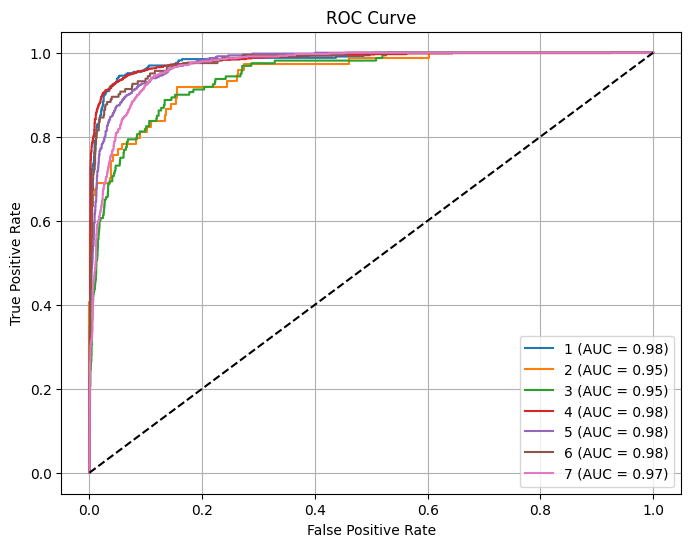

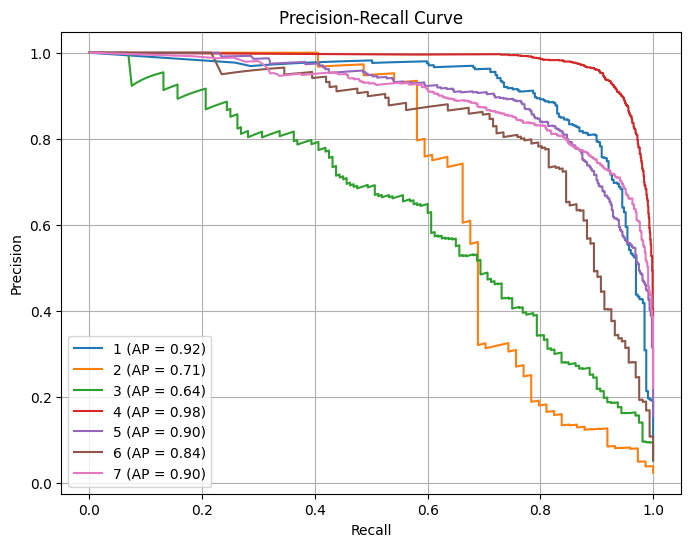

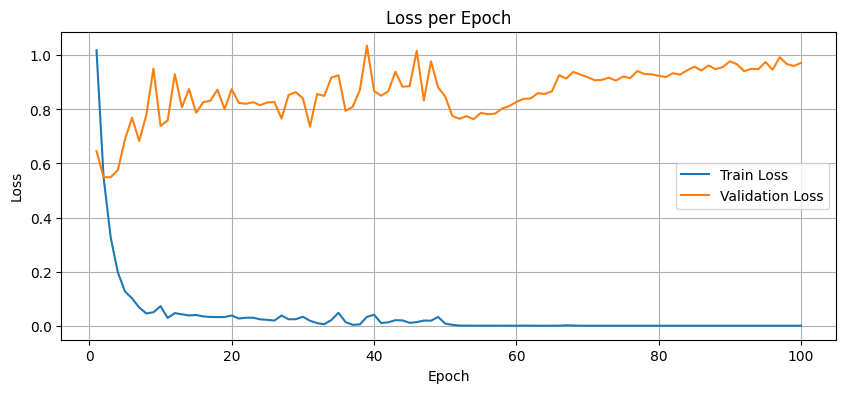

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

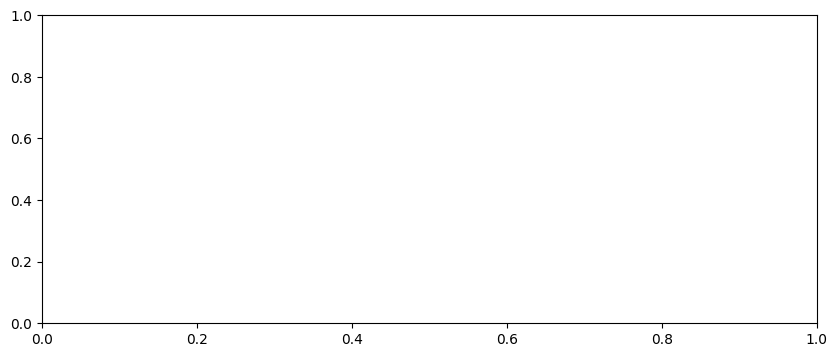

In [ ]:
# Evaluation
def evaluate_model(model, val_loader):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    class_names = val_dataset.classes

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # ROC Curve
    one_hot = np.eye(len(class_names))[all_labels]
    plt.figure(figsize=(8, 6))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(one_hot[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()

    # PR Curve
    plt.figure(figsize=(8, 6))
    for i in range(len(class_names)):
        precision, recall, _ = precision_recall_curve(one_hot[:, i], all_probs[:, i])
        ap_score = average_precision_score(one_hot[:, i], all_probs[:, i])
        plt.plot(recall, precision, label=f'{class_names[i]} (AP = {ap_score:.2f})')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid()
    plt.show()

# Run evaluation
evaluate_model(model, val_loader)

# Loss/Accuracy Plots
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(epochs, train_accs, label='Train Accuracy') # Changed to use train_accs
plt.plot(epochs, val_accs, label='Validation Accuracy') # Changed to use val_accs
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.show()